### Mount Google Drive (Works only on Google Colab)

In [0]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


# Import Packages

In [0]:
import os
import random
import pickle
import zipfile
import numpy as np
from tqdm.autonotebook import tqdm

from PIL import Image

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  


# Define Paths

Define paths of all the required files and directories

In [0]:
GDRIVE_DIR = '/content/gdrive/My Drive'

# File containing the final dataset
ZIP_PATH = os.path.join(GDRIVE_DIR, 'modest_museum_dataset.zip')

In [0]:
# Root path of the dataset
ROOT_DATA_DIR = 'modest_museum_dataset'

# Background Images
BG_DIR = os.path.join(ROOT_DATA_DIR, 'bg')

# Foreground Images
FG_DIR = os.path.join(ROOT_DATA_DIR, 'fg')

# Foreground Masks
FG_MASK_DIR = os.path.join(ROOT_DATA_DIR, 'fg_mask')

# Foreground Background Images
BG_FG_DIR = os.path.join(ROOT_DATA_DIR, 'bg_fg')

# Foreground Background Masks
BG_FG_MASK_DIR = os.path.join(ROOT_DATA_DIR, 'bg_fg_mask')

# Foreground Background Depth Masks
DEPTH_DIR = os.path.join(ROOT_DATA_DIR, 'bg_fg_depth_map')

# File containing image relations
RELATION_FILE = os.path.join(ROOT_DATA_DIR, 'file_map.txt')

# File containing bbox values
BBOX_FILE = os.path.join(ROOT_DATA_DIR, 'bbox.txt')

# Define Shapes

Define shapes of the images in the dataset

In [0]:
# Background
INT_BG_SHAPE = (704, 704)  # Intermediate shape
BG_SHAPE = (224, 224)  # Final shape
BG_SCALE_RATIO = 224 / 704  # Scaling Factor

# Foreground
INT_FG_HEIGHT = 340  # Intermediate shape
FG_HEIGHT = 108  # Final shape

# Data Visualization

Let's visualize some of the foreground and background images

In [0]:
def make_grid(images_list, grid_name, height=140, margin=8, aspect_ratio=False):
    """Combine Images to form a grid.

    Args:
        images (list): List of images to display in grid.
        grid_name (str): Name of the file where grid is stored.
        height (int): Height to which the image will be resized.
        margin (int): Amount of padding between the images in grid.
        aspect_ratio (bool, optional): Create grid while maintaining
            the aspect ratio of the images. (default: False)
    
    Returns:
        Image grid.
    """

    # Create grid template
    widths = []
    if aspect_ratio:
        for img_path in images_list:
            image = Image.open(img_path)
            # Find width according to aspect ratio
            h_percent = height / image.size[1]
            widths.append(int(image.size[0] * h_percent))
    else:
        widths = [height] * len(images_list)
    
    start = 0
    background = Image.new(
        'RGBA', (sum(widths) + (len(images_list) - 1) * margin, height)
    )
    
    # Add images to grid
    for idx, img_path in enumerate(images_list):
        image = Image.open(img_path)
        image = image.resize((widths[idx], height))
        offset = (start, 0)
        start += (widths[idx] + margin)
        background.paste(image, offset)
    
    background.save(f'{grid_name}_grid.png')
    return background

Backgrounds:



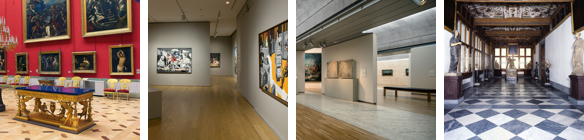

In [0]:
# Display backgrounds
print('Backgrounds:\n')
make_grid([
    os.path.join(BG_DIR, x)
    for x in random.sample(os.listdir(BG_DIR), 4)
], 'bg')

Foregrounds:



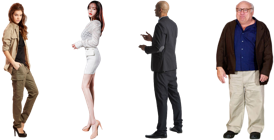

In [0]:
# Display foregrounds
print('Foregrounds:\n')
make_grid([
    os.path.join(FG_DIR, x)
    for x in random.sample(os.listdir(FG_DIR), 4)
], 'fg', margin=30, aspect_ratio=True)

# Rename Images

The images will have to be renamed in a proper structure so that they could be referred to easily.  
The following naming conventions will be followed:
  - **background images**: `bg001.jpeg`, `bg002.jpeg`, ..., `bg100.jpeg`
  - **foreground images**: `fg001.png`, `fg002.png`, ..., `fg100.png`

Foreground images will have a transparent background so they need to be in *PNG* format.

In [0]:
def rename_images(path, prefix):
    """Rename images present in a directory.

    Args:
        path (str): Path to the directory containing the images.
        prefix (str): During renaming, all image names will begin
            with the given prefix.
    """
    for idx, img in enumerate(tqdm(os.listdir(path))):
        image_path = os.path.join(FG_DIR, img)
        os.rename(
            os.path.join(path, img),
            os.path.join(
                path, f'{prefix}{idx+1:03d}{os.path.splitext(img)[1]}'
            )
        )

In [0]:
# Rename background images
print('Renaming background images...')
rename_images(BG_DIR, 'bg')

# Rename foreground images
print('Renaming foreground images...')
rename_images(FG_DIR, 'fg')

Renaming background images...



Renaming foreground images...


# Resize Backgrounds

All the background images are resized into a fixed size of `704x704`.

In [0]:
def resize_images(path, shape):
    """Resize the images present in a directory.

    Args:
        path (str): Path to the directory containing the images.
        shape (tuple): New shape of the images.
    """
    pbar = tqdm(os.listdir(path))
    for idx, bg in enumerate(pbar):
        image_path = os.path.join(path, bg)
        image = Image.open(image_path)
        image = image.resize(shape, Image.ANTIALIAS)
        image.save(image_path)

In [0]:
print('Resizing background images...')
resize_images(BG_DIR, INT_BG_SHAPE)

Resizing background images...


# Mask Creation for Foregrounds

- The pixels in the foreground image are set to 255 (white) where the object is present and rest of the pixels (background) are set to 0 (black).
- The non-zero values in the alpha channel are set to 255, this ensures full opaqueness of the object mask in the image.

In [0]:
def set_background_color(image, bg_colour=(0, 0, 0)):
    """Set background color of an image.

    Args:
        image (PIL Image): Input image.
        bg_color (tuple): New background color.
    
    Returns:
        Image with the specified background color.
    """
    
    if image.mode == 'RGBA':
        alpha = image.convert('RGBA').split()[-1]
        bg = Image.new("RGBA", image.size, bg_colour + (255,))
        bg.paste(image, mask=alpha)
        return bg
    else:
        # If image has no alpha channel then background cannot be changed
        return image

In [0]:
def create_mask(source_dir, target_dir):
    """Create masks.

    Args:
        source_dir (str): Path containing the input image.
        target_dir (str): Path to store the masks.
    """

    # Create target directory if not exists
    if not os.path.exists(target_dir):
        os.makedirs(target_dir)
    
    for fg in tqdm(os.listdir(source_dir)):
        fg_path = os.path.join(source_dir, fg)

        image = Image.open(fg_path)
        img_array = np.array(image)
        img_array[:, :, :-1][img_array[:, :, :-1] == 0] = 255
        img_array[img_array > 0] = 255

        # Create Mask
        mask_path = os.path.join(
            target_dir,
            f'{os.path.splitext(fg)[0]}_mask.png'
        )
        mask = Image.fromarray(img_array)
        mask = set_background_color(mask)
        mask.save(mask_path)

In [0]:
print('Creating foreground masks...')
create_mask(FG_DIR, FG_MASK_DIR)

Creating foreground masks...


Foreground Masks:



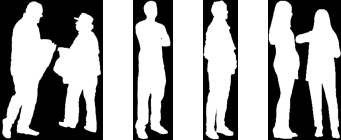

In [0]:
# Display foreground masks
print('Foreground Masks:\n')
make_grid([
    os.path.join(FG_MASK_DIR, x)
    for x in random.sample(os.listdir(FG_MASK_DIR), 4)
], 'fg_mask', margin=30, aspect_ratio=True)

# Resize Foregrounds

All the foreground images are resized to have a fixed height of 340.

In [0]:
def resize_with_aspect_ratio(path, height):
    """Resize the images in a directory with given height while
    maintaining the aspect ratio.

    Args:
        path (str): Path to the directory containing the images.
        height (int): New height of the images.
    """
    pbar = tqdm(os.listdir(path))
    for idx, img_name in enumerate(pbar):
        # Read image
        img_path = os.path.join(path, img_name)
        image = Image.open(img_path)

        # Find width according to aspect ratio
        h_percent = height / image.size[1]
        width = int(image.size[0] * h_percent)

        # Resize and save image
        image = image.resize((width, height), Image.ANTIALIAS)
        image.save(img_path)

In [0]:
print('Resizing foregrounds...')
resize_with_aspect_ratio(FG_DIR, INT_FG_HEIGHT)

print('Resizing foreground masks...')
resize_with_aspect_ratio(FG_MASK_DIR, INT_FG_HEIGHT)

Resizing foregrounds...



Resizing foreground masks...


# Overlaying foregrounds on backgrounds

Foregrounds are overlayed on backgrounds to create background-foreground images. A corresponding mask of background-foreground image will also be created.

## Images created in this step

- Number of foreground images = 100
- Number of background images = 100
- Overlaying foreground on 20 different locations: 100x100x20 = 200,000
- Overlaying horizontally flipped foreground on 20 different locations: 100x100x20 = 200,000

Thus, total number of images in the dataset is **400,000**.

Create necessary directories

In [0]:
if not os.path.exists(BG_FG_MASK_DIR):
    os.makedirs(BG_FG_MASK_DIR)

if not os.path.exists(BG_FG_DIR):
    os.makedirs(BG_FG_DIR)

Overlay foregrounds on backgrounds

In [0]:
def overlay(bg, fg, fg_mask, bbox, flip):
    """Overlay foreground at 20 random positions on the background and
    create a mask for the overlayed images.

    Args:
        bg (str, PIL Image): Background name and image.
        fg (str, PIL Image): Foreground name and image.
        fg_mask (str, PIL Image): Foreground mask name and image.
        flip (bool): True if foreground is LR flipped.
    """

    by, bx, _ = np.array(bg[1]).shape
    fy, fx, _ = np.array(fg[1]).shape

    # Overlay forground 20 times
    name_range = range(1, 21) if not flip else range(21, 41)
    for name_id in name_range:

        # Get coordinates for placing foreground on background
        x = random.randint(0, bx - fx)
        y = random.randint(0, by - fy)

        # Overlay foreground on background
        bg_fg_name = f'{bg[0]}_{fg[0]}_{name_id:02d}.jpeg'
        bg_overlay = bg[1].copy()
        bg_overlay.paste(fg[1], (x, y), fg[1])
        bg_overlay.save(os.path.join(
            BG_FG_DIR, bg_fg_name
        ))

        # Store bbox values
        bbox.append((
            bg_fg_name,  # background-foreground name
            str(int(x * BG_SCALE_RATIO)),  # bbox x-coordinate
            str(int(y * BG_SCALE_RATIO)),  # bbox y-coordinate
            str(int(fg[1].size[0] * BG_SCALE_RATIO)),  # bbox width
            str(int(fg[1].size[1] * BG_SCALE_RATIO)),  # bbox height
        ))

        # Create mask of the overlayed image
        overlay_mask = np.zeros_like(bg[1])
        overlay_mask = Image.fromarray(overlay_mask)
        overlay_mask.paste(fg_mask[1], (x, y), fg_mask[1])
        overlay_mask = overlay_mask.convert(mode='L')  # Convert to 1-channel image
        overlay_mask.save(os.path.join(
            BG_FG_MASK_DIR, f'{os.path.splitext(bg_fg_name)[0]}_mask.jpeg'
        ))

All the images are pre-loaded in memory to save reading from disk repeatedly and save some computation time

In [0]:
foreground = [
    (os.path.splitext(x)[0], Image.open(os.path.join(FG_DIR, x)))
    for x in sorted(os.listdir(FG_DIR))
]
foreground_mask = [
    (os.path.splitext(x)[0], Image.open(os.path.join(FG_MASK_DIR, x)))
    for x in sorted(os.listdir(FG_MASK_DIR))
]

foreground_flip = [
    (x[0], Image.fromarray(np.fliplr(np.array(x[1]))))
    for x in foreground
]
foreground_flip_mask = [
    (x[0], Image.fromarray(np.fliplr(np.array(x[1]))))
    for x in foreground_mask
]

At a time we only process a small set of backgrounds. This is done to avoid running notebook for longer durations.

**Example:**  
If range is set to `range(11, 21)`, then overlay will only be done for backgrounds `bg011.jpeg` to `bg021.jpeg`

In [0]:
print('Overlaying foregrounds on backgrounds...')

# Load background names and foregrounds
bg_list = [f'bg{x:03d}.jpeg' for x in range(41, 51)]
fg_list = list(zip(
    foreground, foreground_mask, foreground_flip, foreground_flip_mask
))

# Start overlay
for bg_img in tqdm(
    bg_list, desc='Backgrounds Completed'
):  # For each background
    bg = (os.path.splitext(bg_img)[0], Image.open(os.path.join(BG_DIR, bg_img)))
    bbox = []
    
    for fg, fg_mask, fg_flip, fg_mask_flip in tqdm(
        fg_list, desc='Overlay Progress', leave=False
    ):  # For each foreground

        # Overlay image
        overlay(
            bg, fg, fg_mask, bbox, False
        )

        # Overlay LR flipped image
        overlay(
            bg, fg_flip, fg_mask_flip, bbox, True
        )

    # Dump bbox values to a file
    with open(BBOX_FILE, 'a') as f:
        for line in bbox:
            f.write('\t'.join(line) + '\n')

Overlaying foregrounds on backgrounds...


In [0]:
# Fetch 4 random foreground-background images to display
img_list = [
    os.path.splitext(x)[0] for x in random.sample(os.listdir(BG_FG_DIR), 8)
]

Foreground-Background Images:



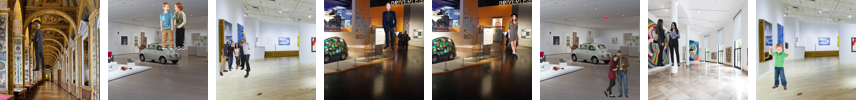

In [0]:
# Display foreground-background images
print('Foreground-Background Images:\n')
make_grid([
    os.path.join(BG_FG_DIR, f'{x}.jpeg')
    for x in img_list
], 'bg_fg', height=100)

Foreground-Background Masks:



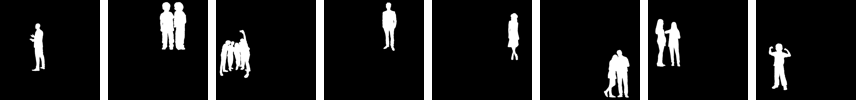

In [0]:
# Display foreground-background masks
print('Foreground-Background Masks:\n')
make_grid([
    os.path.join(BG_FG_MASK_DIR, f'{x}_mask.jpeg')
    for x in img_list
], 'bg_fg_mask', height=100)

# Depth Map

To create the monocular depth estimation map of the background-foreground images, we use pretrained DenseNet-201.

### Set TensorFlow version to 1.x

In [0]:
%tensorflow_version 1.x

TensorFlow 1.x selected.


### Download Weights for Transfer Learning

In [0]:
!wget https://s3-eu-west-1.amazonaws.com/densedepth/nyu.h5

--2020-05-06 19:52:19--  https://s3-eu-west-1.amazonaws.com/densedepth/nyu.h5
Resolving s3-eu-west-1.amazonaws.com (s3-eu-west-1.amazonaws.com)... 52.218.110.107
Connecting to s3-eu-west-1.amazonaws.com (s3-eu-west-1.amazonaws.com)|52.218.110.107|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 172897376 (165M) [application/h5]
Saving to: ‘nyu.h5’

nyu.h5              100%[===================>] 164.89M  75.0MB/s    in 2.2s    

2020-05-06 19:52:21 (75.0 MB/s) - ‘nyu.h5’ saved [172897376/172897376]



### Generate Depth Masks

In [0]:
from densedepth import depth_map, load_densenet

Using TensorFlow backend.


In [0]:
model = load_densenet('nyu.h5')

Loading model...
Instructions for updating:
If using Keras pass *_constraint arguments to layers.




Model loaded (nyu.h5).


In [0]:
depth_map(model, BG_FG_DIR, batch_size=40)


Predicting depth maps...




Predictions saved in modest_museum_dataset/bg_fg_depth_map


In [0]:
# Rename depth map files
print('Renaming Depth Maps...')
for img in tqdm(os.listdir(DEPTH_DIR)):
    depth_img_name = f'{os.path.splitext(img)[0]}_depth_map.jpeg'
    os.rename(
        os.path.join(DEPTH_DIR, img),
        os.path.join(DEPTH_DIR, depth_img_name)
    )

Renaming Depth Maps...


Foreground-Background Depth Maps:



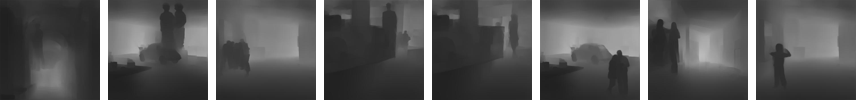

In [0]:
# Display foreground-background depth maps
print('Foreground-Background Depth Maps:\n')
make_grid([
    os.path.join(DEPTH_DIR, f'{x}_depth_map.jpeg')
    for x in img_list
], 'bg_fg_depth_map', height=100)

# Final Resize of the Dataset

Now we resize the background images, foreground-background images, foreground-background mask and foreground-background depth maps to 224x224.

The foreground images and their masks are also resized to a height of 108.

In [0]:
# Backgrounds
print('Resizing backgrounds...')
resize_images(BG_DIR, BG_SHAPE)

# Foregrounds
print('Resizing foregrounds...')
resize_with_aspect_ratio(FG_DIR, FG_HEIGHT)

# Foreground masks
print('Resizing foreground masks...')
resize_with_aspect_ratio(FG_MASK_DIR, FG_HEIGHT)

Resizing backgrounds...



Resizing foregrounds...



Resizing foreground masks...


In [0]:
# Foreground-Background
print('Resizing background-foreground images...')
resize_images(BG_FG_DIR, BG_SHAPE)

# Foreground-Background Mask
print('Resizing background-foreground masks...')
resize_images(BG_FG_MASK_DIR, BG_SHAPE)

# Foreground-Background Depth Map
print('Resizing background-foreground depth maps...')
resize_images(DEPTH_DIR, BG_SHAPE)

Resizing background-foreground images...



Resizing background-foreground masks...



Resizing background-foreground depth maps...


# Saving Dataset

After the images have been created, we'll store all of them in a zip file.

In [0]:
def archive_data(data_dir):
    """Archive contents of a directory in a zip file.

    Args:
        data_dir (str): Path to directory containing files to be zipped.
    """
    data_zip = zipfile.ZipFile(ZIP_PATH, mode='a')
    for file in tqdm(os.listdir(data_dir)):
        data_zip.write(os.path.join(data_dir, file))
    data_zip.close()

In [0]:
# Archive backgrounds
print('Archiving backgrounds...')
archive_data(BG_DIR)

# Archive foregrounds
print('Archiving foregrounds...')
archive_data(FG_DIR)

# Archive foreground masks
print('Archiving foreground masks...')
archive_data(FG_MASK_DIR)

Archiving backgrounds...



Archiving foregrounds...



Archiving foreground masks...


In [0]:
# Foreground-Background
print('Archiving background-foreground images...')
archive_data(BG_FG_DIR)

# Foreground-Background Mask
print('Archiving background-foreground masks...')
archive_data(BG_FG_MASK_DIR)

# Foreground-Background Depth Map
print('Archiving background-foreground depth maps...')
archive_data(DEPTH_DIR)

Archiving background-foreground images...



Archiving background-foreground masks...



Archiving background-foreground depth maps...


# Dump file relations

The relationships between various parts of the dataset are dumped in a file named `file_map.txt`.

In [0]:
# Dump relations to file
with open(RELATION_FILE, 'w') as f_dump:
    for bg in tqdm(range(1, 101), desc='Progress'):
        bg_name = f'bg{bg:03d}'
        for fg in range(1, 101):
            fg_name = f'fg{fg:03d}'
            for overlay in range(1, 41):
                overlay_name = f'{bg_name}_{fg_name}_{overlay:02d}'
                f_dump.write(
                    f'{bg_name}\t{overlay_name}\t{overlay_name}_mask\t{overlay_name}_depth_map\n'
                )

In [0]:
# Archive relation dump
data_zip = zipfile.ZipFile(ZIP_PATH, mode='a')
data_zip.write(RELATION_FILE)
data_zip.close()

# Dump Bounding Box Data
The bounding box data for each background-foreground image is dumped in a file named `bbox.txt`.

In [0]:
# Archive bbox data
data_zip = zipfile.ZipFile(ZIP_PATH, mode='a')
data_zip.write(BBOX_FILE)
data_zip.close()